In [4]:
import torch
device = torch.device("mps")
device

device(type='mps')

In [5]:
pip install -U albumentations


Note: you may need to restart the kernel to use updated packages.


In [6]:
%cd  /Users/gman/Desktop/Traffic_Sign_Recognition_using_PyTorch_and_Deep_Learning/src

/Users/gman/Desktop/Traffic_Sign_Recognition_using_PyTorch_and_Deep_Learning/src


In [88]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
from glob import glob
from torchvision.transforms.functional import to_pil_image, to_tensor
from torch.nn import functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
from model import build_model  # Ensure this is correctly defined elsewhere

# Define the device to use for Tensor computations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def gaussian_blur(image, kernel_size=5, sigma=2):
    """
    Applies Gaussian blurring using OpenCV.
    """
    image_np = image.squeeze(0).permute(1, 2, 0).numpy()
    image_np = (image_np * 255).astype(np.uint8)  # Scale to 0-255 range for CV2
    blurred_np = cv2.GaussianBlur(image_np, (kernel_size, kernel_size), sigmaX=sigma)
    blurred_tensor = to_tensor(blurred_np).unsqueeze(0)
    return blurred_tensor

def pgd_attack(model, image, epsilon, alpha, num_steps, y_true, targeted=False, random_start=True):
    model.eval()
    perturbed_image = image.clone().detach()
    if random_start:
        perturbed_image += (2 * epsilon * torch.rand_like(image) - epsilon)
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
    perturbed_image.requires_grad = True
    for _ in range(num_steps):
        outputs = model(perturbed_image)
        model.zero_grad()
        loss = F.cross_entropy(outputs, y_true)
        if targeted:
            loss = -loss
        loss.backward()
        with torch.no_grad():
            perturbed_image.data += alpha * perturbed_image.grad.sign()
            perturbation = torch.clamp(perturbed_image - image, -epsilon, epsilon)
            perturbed_image.data = torch.clamp(image + perturbation, 0, 1)
        perturbed_image.grad.zero_()
    return perturbed_image.detach()

def fgsm_attack(model, x, y, epsilon, iterations=1):
    model.eval()
    x_adv = x.clone().detach().requires_grad_(True)
    output = model(x_adv)
    loss = F.cross_entropy(output, y)
    model.zero_grad()
    loss.backward()
    with torch.no_grad():
        x_adv += epsilon * x_adv.grad.sign()
        x_adv = torch.clamp(x_adv, 0, 1)
    return x_adv.detach()

def createAdversarialImages():
    sign_names_df = pd.read_csv('../input/signnames.csv')
    gt_df = pd.read_csv('../input/GTSRB_Final_Test_GT/GT-final_test.csv', delimiter=';')
    gt_df = gt_df.set_index('Filename', drop=True)
    model = build_model(pretrained=False, fine_tune=False, num_classes=43).to(device)
    model.eval()
    model.load_state_dict(torch.load('../outputs/model.pth', map_location=device)['model_state_dict'])
    transform = A.Compose([ToTensorV2()])
    base_dir = '../input/GTSRB_Final_Test_Images/GTSRB/Final_Test'
    blur_dir = os.path.join(base_dir, 'gaussian_blur')
    pgd_dir = os.path.join(base_dir, 'pgd_attack')
    fgsm_dir = os.path.join(base_dir, 'fgsm_attack')
    os.makedirs(blur_dir, exist_ok=True)
    os.makedirs(pgd_dir, exist_ok=True)
    os.makedirs(fgsm_dir, exist_ok=True)
    all_images = glob(os.path.join(base_dir, 'Images', '*.ppm'))
    for image_path in all_images:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype(np.float32) / 255.0
        image_tensor = transform(image=image)['image'].unsqueeze(0).to(device)
        blurred_tensor = gaussian_blur(image_tensor)
        blurred_image = to_pil_image(blurred_tensor.squeeze(0))
        blurred_image.save(os.path.join(blur_dir, os.path.basename(image_path)), format='PPM')
        y_true = torch.tensor([gt_df.loc[os.path.basename(image_path), 'ClassId']]).to(device)
        pgd_tensor = pgd_attack(model, image_tensor, 0.1, 0.04, 10, y_true)
        pgd_image = to_pil_image(pgd_tensor.squeeze(0))
        pgd_image.save(os.path.join(pgd_dir, os.path.basename(image_path)), format='PPM')
        fgsm_tensor = fgsm_attack(model, image_tensor, y_true, 0.1, 1)
        fgsm_image = to_pil_image(fgsm_tensor.squeeze(0))
        fgsm_image.save(os.path.join(fgsm_dir, os.path.basename(image_path)), format='PPM')

# To execute the function
createAdversarialImages()


[INFO]: Not loading pre-trained weights
[INFO]: Freezing hidden layers...


/Users/gman/anaconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gman/anaconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


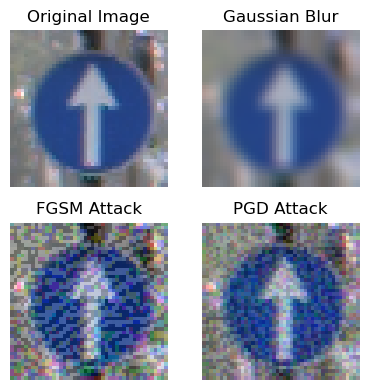

In [83]:
from PIL import Image
import matplotlib.pyplot as plt

def visualize_images_in_grid_with_titles(filenames, titles):
    """
    Loads and visualizes multiple PPM images in a 2x2 grid with titles.
    
    Args:
        filenames (list of str): The paths to the PPM image files.
        titles (list of str): Titles for each image corresponding to their folders.
    """
    fig, axs = plt.subplots(2, 2, figsize=(4, 4))  # Set up a 2x2 grid of subplots
    axs = axs.ravel()  # Flatten the 2x2 grid to a 1D array for easier indexing
    
    for i, (filename, title) in enumerate(zip(filenames, titles)):
        image = Image.open(filename)
        axs[i].imshow(image)
        axs[i].set_title(title)  # Set the title for each subplot
        axs[i].axis('off')  # Turn off axis numbers and ticks for each subplot

    plt.tight_layout()
    plt.show()

# Example usage
base_path = "/Users/gman/Desktop/Traffic_Sign_Recognition_using_PyTorch_and_Deep_Learning/input/GTSRB_Final_Test_Images/GTSRB/Final_Test"  # Change this to the correct base path
image_name = "11776.ppm"  # Your image name

folders = ["Images", "gaussian_blur", "fgsm_attack", "pgd_attack"]
titles = ["Original Image", "Gaussian Blur", "FGSM Attack", "PGD Attack"]  # Titles based on folders
file_paths = [f"{base_path}/{folder}/{image_name}" for folder in folders]

visualize_images_in_grid_with_titles(file_paths, titles)


In [89]:
!python cam.py gaussian_blur

Capturing images of type: gaussian_blur
[INFO]: Not loading pre-trained weights
/Users/gman/anaconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gman/anaconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
[INFO]: Freezing hidden layers...
/Users/gman/Desktop/Traffic_Sign_Recognition_using_PyTorch_and_Deep_Learning/src/cam.py:166: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(outputs).data.squeeze()
Image: 1
Image: 2
Image: 3
Image: 4
Image: 5
Image: 6
Image: 7
Im

In [90]:
!python cam.py pgd_attack


Capturing images of type: pgd_attack
[INFO]: Not loading pre-trained weights
/Users/gman/anaconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gman/anaconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
[INFO]: Freezing hidden layers...
/Users/gman/Desktop/Traffic_Sign_Recognition_using_PyTorch_and_Deep_Learning/src/cam.py:166: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(outputs).data.squeeze()
Image: 1
Image: 2
Image: 3
Image: 4
Image: 5
Image: 6
Image: 7
Image

In [91]:
!python cam.py fgsm_attack

Capturing images of type: fgsm_attack
[INFO]: Not loading pre-trained weights
/Users/gman/anaconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gman/anaconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
[INFO]: Freezing hidden layers...
/Users/gman/Desktop/Traffic_Sign_Recognition_using_PyTorch_and_Deep_Learning/src/cam.py:166: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(outputs).data.squeeze()
Image: 1
Image: 2
Image: 3
Image: 4
Image: 5
Image: 6
Image: 7
Imag

In [71]:
import os
import shutil

# Define the paths to the directories
base_dir = '../input/GTSRB_Final_Test_Images/GTSRB/Final_Test'
gaussian_blur_dir = os.path.join(base_dir, 'gaussian_blur')
images_dir = os.path.join(base_dir, 'Images')
test_orig_dir = os.path.join(base_dir, 'original_subset')

# Ensure the target directory exists
os.makedirs(test_orig_dir, exist_ok=True)

# Get a list of filenames from the gaussian_blur directory
gaussian_files = os.listdir(gaussian_blur_dir)
gaussian_filenames = [os.path.splitext(file)[0] for file in gaussian_files]

# Copy files from the Images directory to test_orig if they exist in gaussian_blur
for filename in gaussian_filenames:
    src_path = os.path.join(images_dir, filename + '.ppm')
    dst_path = os.path.join(test_orig_dir, filename + '.ppm')
    if os.path.exists(src_path):
        shutil.copy2(src_path, dst_path)
        print(f"Copied {src_path} to {dst_path}")
    else:
        print(f"File does not exist: {src_path}")


Copied ../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/06578.ppm to ../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/original_subset/06578.ppm
Copied ../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/11004.ppm to ../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/original_subset/11004.ppm
Copied ../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/01217.ppm to ../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/original_subset/01217.ppm
Copied ../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/00109.ppm to ../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/original_subset/00109.ppm
Copied ../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/09893.ppm to ../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/original_subset/09893.ppm
Copied ../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/07666.ppm to ../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/original_subset/07666.ppm
Copied ../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/08555.ppm to ../in

In [9]:
pwd

'/Users/gman/Desktop/Traffic_sign_clone_small/src'

In [92]:
!python cam.py original


Capturing images of type: original
[INFO]: Not loading pre-trained weights
/Users/gman/anaconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gman/anaconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
[INFO]: Freezing hidden layers...
/Users/gman/Desktop/Traffic_Sign_Recognition_using_PyTorch_and_Deep_Learning/src/cam.py:166: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(outputs).data.squeeze()
Image: 1
Image: 2
Image: 3
Image: 4
Image: 5
Image: 6
Image: 7
Image: 

In [93]:
# %cd '/Users/gman/Desktop/Traffic_Sign_Recognition_using_PyTorch_and_Deep_Learning/input/GTSRB_Final_Test_Images/GTSRB/Final_Test/fgsm_attack'
# !rm *.ppm
# %cd '/Users/gman/Desktop/Traffic_Sign_Recognition_using_PyTorch_and_Deep_Learning/input/GTSRB_Final_Test_Images/GTSRB/Final_Test/gaussian_blur'
# !rm *.ppm
# %cd '/Users/gman/Desktop/Traffic_Sign_Recognition_using_PyTorch_and_Deep_Learning/input/GTSRB_Final_Test_Images/GTSRB/Final_Test/pgd_attack'
# !rm *.ppm
# %cd '/Users/gman/Desktop/Traffic_Sign_Recognition_using_PyTorch_and_Deep_Learning/input/GTSRB_Final_Test_Images/GTSRB/Final_Test/original_subset'
# !rm *.ppm
# %cd /Users/gman/Desktop/Traffic_Sign_Recognition_using_PyTorch_and_Deep_Learning/src

# Convert .ppm to .jpg (Optional)

In [36]:
import cv2
import os
import glob

def convert_ppm_to_jpg(source_dir, target_dir):
    """
    Converts all PPM images in the specified directory to JPG format and saves them in a new directory.
    
    Args:
        source_dir (str): The directory containing PPM images.
        target_dir (str): The directory to save converted JPG images.
    """
    # Check if the source directory exists
    if not os.path.exists(source_dir):
        print(f"Source directory '{source_dir}' does not exist.")
        return

    # Create target directory if it does not exist
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
        print(f"Created directory '{target_dir}'.")

    # Glob to find all ppm files in the source directory
    ppm_files = glob.glob(os.path.join(source_dir, '*.ppm'))
    if not ppm_files:
        print(f"No .ppm files found in '{source_dir}'.")
        return

    for ppm_path in ppm_files:
        try:
            # Read the image using cv2
            image = cv2.imread(ppm_path)
            if image is None:
                print(f"Failed to read image from '{ppm_path}'.")
                continue

            # No need to convert to RGB as we are saving directly to JPEG which expects BGR
            # image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Generate new file path with the .jpg extension
            base_name = os.path.basename(ppm_path)
            jpg_name = os.path.splitext(base_name)[0] + '.jpg'
            jpg_path = os.path.join(target_dir, jpg_name)
            
            # Save the image in JPG format
            cv2.imwrite(jpg_path, image)  # Save directly using the original BGR format
            print(f"Converted and saved {jpg_name}")
        except Exception as e:
            print(f"An error occurred processing {ppm_path}: {e}")


source_directory = '../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images'  # adjust path as needed
target_directory = '../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images_jpg'

convert_ppm_to_jpg(source_directory, target_directory)


Converted and saved 06578.jpg
Converted and saved 11004.jpg
Converted and saved 01217.jpg
Converted and saved 00109.jpg
Converted and saved 09893.jpg
Converted and saved 07666.jpg
Converted and saved 08555.jpg
Converted and saved 03400.jpg
Converted and saved 05071.jpg
Converted and saved 05717.jpg
Converted and saved 02078.jpg
Converted and saved 03366.jpg
Converted and saved 04409.jpg
Converted and saved 07100.jpg
Converted and saved 08233.jpg
Converted and saved 01571.jpg
Converted and saved 11762.jpg
Converted and saved 07114.jpg
Converted and saved 10468.jpg
Converted and saved 08227.jpg
Converted and saved 01565.jpg
Converted and saved 09139.jpg
Converted and saved 11776.jpg
Converted and saved 05703.jpg
Converted and saved 03372.jpg
Converted and saved 03414.jpg
Converted and saved 12519.jpg
Converted and saved 05065.jpg
Converted and saved 11010.jpg
Converted and saved 01203.jpg
Converted and saved 09887.jpg
Converted and saved 07672.jpg
Converted and saved 08541.jpg
Converted 

# Visualize .ppm image ( Just one )

In [ ]:
# from PIL import Image
# import matplotlib.pyplot as plt

# def visualize_ppm(filename):
#     """
#     Loads and visualizes a PPM image.
    
#     Args:
#         filename (str): The path to the PPM image file.
#     """
#     image = Image.open(filename)
#     plt.imshow(image)
#     plt.axis('off')  # Turn off axis numbers and ticks
#     plt.show()
# print("Original")
# visualize_ppm('../input/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/00000.ppm')




In [93]:
# ##################          Gaussian Blur             ################## 

# import cv2
# import numpy as np
# import torch
# from torchvision.transforms.functional import to_tensor, to_pil_image

# def gaussian_blur(image, kernel_size=5, sigma=0):
#     """
#     Applies Gaussian blurring using OpenCV.
    
#     Args:
#         image (torch.Tensor): The input image tensor.
#         kernel_size (int): The size of the Gaussian kernel. Default is 5.
#         sigma (float): The standard deviation of the Gaussian kernel. Default is 0.
        
#     Returns:
#         torch.Tensor: The blurred image tensor.
#     """
#     # Convert tensor to numpy array
#     image_np = image.squeeze(0).permute(1, 2, 0).numpy()
#     image_np = (image_np * 255).astype(np.uint8)  # Scale to 0-255 range for CV2

#     # Apply Gaussian Blur using OpenCV
#     blurred_np = cv2.GaussianBlur(image_np, (kernel_size, kernel_size), sigmaX=sigma)

#     # Convert back to tensor
#     blurred_tensor = to_tensor(blurred_np).unsqueeze(0)
#     return blurred_tensor



# ##################          PGD attack             ################## 

# import torch
# import torch.nn.functional as F

# def pgd_attack(model, image, epsilon, alpha, num_steps, y_true, targeted=False):
#     """
#     Perform a PGD attack on an input image.

#     Args:
#         model (torch.nn.Module): The neural network model.
#         image (torch.Tensor): Input image tensor (should be normalized between 0 and 1).
#         epsilon (float): Maximum perturbation amount.
#         alpha (float): Step size per iteration.
#         num_steps (int): Number of iterations to perform the attack.
#         y_true (torch.Tensor): True labels for the image.
#         targeted (bool): Set to True for targeted attacks, False for untargeted.

#     Returns:
#         torch.Tensor: An adversarial example created from the input image.
#     """
#     model.eval()  # Ensure the model is in eval mode for consistent behavior
#     perturbed_image = image.clone().detach().requires_grad_(True)  # Initialize the perturbed image

#     for _ in range(num_steps):
#         outputs = model(perturbed_image)
#         model.zero_grad()  # Zero gradients to avoid accumulation

#         # Calculate the loss
#         loss = F.cross_entropy(outputs, y_true)
#         if targeted:
#             loss = -loss  # Maximize the loss for targeted attack
#         # Compute gradients
#         loss.backward()

#         # Apply PGD formula to adjust the image
#         with torch.no_grad():
#             # Calculate the step using the sign of the gradients
#             perturbed_image.data += alpha * perturbed_image.grad.sign()
#             # Project back into the epsilon-ball and clip to valid image range
#             perturbed_image.data = torch.clamp(perturbed_image.data, image - epsilon, image + epsilon)
#             perturbed_image.data = torch.clamp(perturbed_image.data, 0, 1)

#         # Detach and re-attach requires_grad to update gradients in next iteration
#         perturbed_image = perturbed_image.detach().requires_grad_(True)

#     return perturbed_image.detach()  # Return the perturbed image detached from the computation graph



# ##################          fgsm_attack             ################## 
# def fgsm_attack(model, x, y, epsilon, iterations):
#     """
#     Performs an untargeted adversarial attack using the FGSM method.

#     Args:
#         model (torch.nn.Module): The neural network model.
#         x (torch.Tensor): Input image tensor (should be normalized between 0 and 1).
#         y (torch.Tensor): True labels corresponding to x.
#         epsilon (float): The perturbation magnitude.
#         iterations (int): Number of iterations to apply the perturbation (usually 1 for FGSM).

#     Returns:
#         torch.Tensor: Adversarial image tensor with the same shape as input x.
    
#     """
#     model.eval()  # Set model to evaluation mode
#     x_adv = x.clone().detach().requires_grad_(True)  # Create a copy of x to modify
#     y = y.clone().detach()

#     for _ in range(iterations):
#         output = model(x_adv)
#         loss = F.cross_entropy(output, y)
#         model.zero_grad()  # Zero out previous gradients
#         loss.backward()  # Compute gradients with respect to input image

#         # Apply FGSM attack by adjusting the image pixels in the direction of the gradients
#         with torch.no_grad():
#             x_adv = x_adv + epsilon * x_adv.grad.sign()
#             x_adv = torch.clamp(x_adv, 0, 1)  # Ensure the adversarial image is still valid

#         # Reset requires_grad to True to compute new gradients in next iteration if necessary
#         x_adv = x_adv.detach().requires_grad_(True)

#     return x_adv

# # Example usage:
# # Assuming 'model' is loaded and set up, 'images' and 'labels' are prepared tensors
# # model = load_pretrained_model()
# # images, labels = load_data()
# # epsilon = 0.01  # Perturbation magnitude
# # num_iter = 1  # FGSM typically uses 1 iteration
# # adversarial_images = untargeted_attack(model, images, labels

In [1]:
%cd outputs/test_results

/Users/gman/Desktop/Traffic_sign_clone_small/outputs/test_results


In [3]:
import os

# List of folders to create
list_operations = [
    "baseline_original_images",
    "baseline_gaussian_blur",
    "baseline_fgsm_attack",
    "baseline_pgd_attack",
    "de-gaussian_blur",
    "de-fgsm_attack",
    "de-pgd_attack",
    "de-fgsm_attack_light",
    "de-pgd_attack_light",
    "de-gaussian_blur_light"
]

# Specify the directory where you want to create the folders
base_directory = './'

# Create folders
for folder_name in list_operations:
    folder_path = os.path.join(base_directory, folder_name)
    os.makedirs(folder_path, exist_ok=True)
    print(f"Created folder: {folder_path}")


Created folder: ./baseline_original_images
Created folder: ./baseline_gaussian_blur
Created folder: ./baseline_fgsm_attack
Created folder: ./baseline_pgd_attack
Created folder: ./de-gaussian_blur
Created folder: ./de-fgsm_attack
Created folder: ./de-pgd_attack
Created folder: ./de-fgsm_attack_light
Created folder: ./de-pgd_attack_light
Created folder: ./de-gaussian_blur_light


In [ ]:
# baseline_original_images
# baseline_gaussian_blur
# baseline_fgsm_attack
# baseline_pgd_attack
# de-gaussian_blur
# de-fgsm_attack
# de-pgd_attack
# de-fgsm_attack_light
# de-pgd_attack_light
# de-gaussian_blur_light



In [18]:
%cd /Users/gman/Desktop/Traffic_sign_clone_small/src

/Users/gman/Desktop/Traffic_sign_clone_small/src


In [20]:
!python cam.py de-gaussian_blur_light

Capturing images of type: de-gaussian_blur_light
Image_type was found: de-gaussian_blur_light
[INFO]: Not loading pre-trained weights
/Users/gman/anaconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gman/anaconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
[INFO]: Freezing hidden layers...
/Users/gman/Desktop/Traffic_sign_clone_small/src/cam.py:151: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(outputs).data.squeeze()
Image: 1
Image: 2
Image: 3
Image: 4
Image: 

In [ ]:
    gt_df = gt_df.set_index('Filename', drop=True)
